In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from numpy import cos, sin, tan
norm = np.linalg.norm


## Environment Parameters

In [3]:
h_LMO = 400 # km
R_MARS = 3396.19 
MU_MARS = 42828.3 # km3/s2

r_LMO = h_LMO + R_MARS
r_GMO = 20424.2

intrument_fov = np.deg2rad(35)

theta_dot_LMO = np.sqrt(MU_MARS / r_LMO**3)
theta_dot_GMO = np.sqrt(MU_MARS / r_GMO**3)

raan_LMO = np.deg2rad(20)
inc_LMO = np.deg2rad(30)
theta0_LMO = np.deg2rad(60)

raan_GMO = np.deg2rad(0)
inc_GMO = np.deg2rad(0)
theta0_GMO = np.deg2rad(250)

## Mission Pointing Scenarios

In [4]:
def in_eclipse(position):
    return position[1] <= 0

def gmo_in_view(lmo_pos, gmo_pos):
    fov = np.deg2rad(35)
    angular_difference = np.arccos(np.dot(lmo_pos, gmo_pos) / (norm(lmo_pos) * norm(gmo_pos)))
    return angular_difference <= fov
    

## Helper Functions

In [5]:
def euler_3_rotation(x):
    
    return np.array([
    [cos(x), sin(x), 0],
    [-sin(x), cos(x), 0],
    [0,0,1]])

def euler_1_rotation(x):
    
    return np.array([
    [1,0,0],
    [0, cos(x), sin(x)],
    [0, -sin(x), cos(x)]])

def orbit_dcm(raan, inclination, theta):
    return euler_3_rotation(theta) @ \
        euler_1_rotation(inclination) @ euler_3_rotation(raan)

def theta_circular(radius, time, initial_theta):
    return initial_theta + np.sqrt(MU_MARS / radius**3) * time

def inertial_position(radius, dcm):
    orbit_position = np.array([radius, 0, 0])
    return dcm.T @ orbit_position

def lmo_position(t):
    theta = theta_circular(r_LMO, t, theta0_LMO)
    dcm = orbit_dcm(raan_LMO, inc_LMO, theta)
    return inertial_position(r_LMO, dcm)

def gmo_position(t):
    theta = theta_circular(r_GMO, t, theta0_GMO)
    dcm = orbit_dcm(raan_GMO, inc_GMO, theta)
    return inertial_position(r_GMO, dcm)

def inertial_velocity(radius, dcm):
    theta_dot = np.sqrt(MU_MARS / radius**3)
    orbit_velocity = np.array([0, radius * theta_dot, 0])
    return dcm.T @ orbit_velocity

def dcm_RsN(t):
    """Sun pointing reference frame DCM relative to inertial frame"""
    return np.array([
        [-1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]
    ])

def dcm_RnO(t):
    """Nadir pointing reference frame DCM relative to orbit frame"""
    return np.array([
        [-1, 0, 0],
        [0, 1, 0],
        [0, 0, -1]
    ])
    
def dcm_RnN(t):
    """Nadir pointing reference frame DCM relative to inertial frame"""
    theta = theta_circular(r_LMO, t, theta0_LMO)
    dcm_ON = orbit_dcm(raan_LMO, inc_LMO, theta)
    
    return dcm_RnO(t) @ dcm_ON
    
def dcm_RcN(t):
    """Comms pointing reference frame DCM relative to inertial frame"""
    theta_GMO = theta_circular(r_GMO, t, theta0_GMO)
    dcm_ON_GMO = orbit_dcm(raan_GMO, inc_GMO, theta_GMO)
    
    theta_LMO = theta_circular(r_LMO, t, theta0_LMO)
    dcm_ON_LMO = orbit_dcm(raan_LMO, inc_LMO, theta_LMO)
    
    r_mother_GMOFrame = np.array([r_GMO, 0, 0])
    r_daughter_LMOFrame = np.array([r_LMO, 0, 0])
    
    r_mother_Nframe = dcm_ON_GMO.T @ r_mother_GMOFrame
    r_daughter_Nframe = dcm_ON_LMO.T @ r_daughter_LMOFrame
    delta_r = r_mother_Nframe - r_daughter_Nframe
    
    r1 = -delta_r / norm(delta_r)
    r2 = np.cross(delta_r, np.array([0,0,1]))
    r2 /= norm(r2)
    r3 = np.cross(r1, r2)
    return np.vstack([r1,r2,r3]).T
    
def omega_RnN(t):
    """
    Returns the relative angular velocity of the nadir frame to 
    the inertial frame in inertial frame components
    """
    dcm_nadir_N = dcm_RnN(t)
    omega_LMO_N_LMOFRAME = np.array([0,0,theta_dot_LMO])
    omega_nadir_N_inertialFrame = dcm_nadir_N.T @ omega_LMO_N_LMOFRAME
    return omega_nadir_N_inertialFrame

def omega_RsN(t):
    
    theta = theta_circular(r_LMO, t, theta0_LMO)
    dcm_ON = orbit_dcm(raan_LMO, inc_LMO, theta)
    
    omega_LMO_N_LMOFRAME = np.array([0,0,theta_dot_LMO])
    omega_sun_N_inertialFrame = dcm_ON.T @ omega_LMO_N_LMOFRAME
    return omega_sun_N_inertialFrame    
    
    
def omega_RcN(t, step_size=1):
    
    dcm_0 = dcm_RcN(t)
    dcm1 = dcm_RcN(t + step_size)
    d_dcm_dt = (dcm1 - dcm_0) / step_size

    omega_tilde = -dcm_0.T @ d_dcm_dt
    return np.array([omega_tilde[2][1],
                     omega_tilde[0][2],
                     omega_tilde[1][0]])

def tilde(x):
    return np.array([
        [0, -x[2], x[1]],
        [x[2], 0, -x[0]],
        [-x[1], x[0], 0]
    ])
    
def dcm2euler_param(dcm):
    
    trace = np.trace(dcm)
    b02 = 0.25 * (1 + trace)
    b12 = 0.25 * (1 + 2*dcm[0][0] - trace)
    b22 = 0.25 * (1 + 2*dcm[1][1] - trace)
    b32 = 0.25 * (1 + 2*dcm[2][2] - trace)
    
    if b02 == max(b02, b12, b22, b32):
        b0 = np.sqrt(b02)
        b1 = (dcm[1][2]-dcm[2][1]) / (4 * b0)
        b2 = (dcm[2][0]-dcm[0][2]) / (4 * b0)
        b3 = (dcm[0][1]-dcm[1][2]) / (4 * b0)
        return np.array([b0, b1, b2, b3])
    
    if b12 == max(b02, b12, b22, b32):
        b1 = np.sqrt(b12)
        b0 = (dcm[1][2]-dcm[2][1]) / (4 * b1)
        b2 = (dcm[0][1]+dcm[1][0]) / (4 * b1)
        b3 = (dcm[2][0]+dcm[0][2]) / (4 * b1)
        return np.array([b0, b1, b2, b3])
    
    if b22 == max(b02, b12, b22, b32):
        b2 = np.sqrt(b22)
        b1 = (dcm[0][1]+dcm[1][0]) / (4 * b2)
        b0 = (dcm[2][0]-dcm[0][2]) / (4 * b2)
        b3 = (dcm[1][2]+dcm[2][1]) / (4 * b2)
        return np.array([b0, b1, b2, b3])
    else:
        b3 = np.sqrt(b32)
        b1 = (dcm[2][0]+dcm[0][2]) / (4 * b3)
        b2 = (dcm[1][2]+dcm[2][1]) / (4 * b3)
        b0 = (dcm[0][1]-dcm[1][2]) / (4 * b3)
        return np.array([b0, b1, b2, b3])

def dcm2mrp(dcm):
    if np.isclose(np.trace(dcm), -1.0):
        quat = dcm2euler_param(dcm)
        sigma = quat[1:] / (1 + quat[0])
        return sigma
    trace_term = (np.trace(dcm) + 1)**0.5
    denom = (trace_term*(trace_term+2))
    num = np.array([
        dcm[1][2] - dcm[2][1],
        dcm[2][0] - dcm[0][2],
        dcm[0][1] - dcm[1][0]
    ])
    return num/denom

def mrp_subtract(mrp1, mrp2):
    
    norm1 = norm(mrp1)
    norm2 = norm(mrp2)
    
    num = (1 - norm2**2)*norm1 - (1-norm1**2)*norm2 + 2*np.cross(mrp1, mrp2)
    denom = 1 + (norm1*norm2)**2 + 2*np.dot(mrp1, mrp2)
    
    result = num/denom
    result_norm = norm(result)
    if result_norm >= 1:
        result = -result/result_norm**2
        
    return result

def attitude_state_error(t, mrp_body, omega_body, ref_orientation, omega_reference):
    
    ref_mrp = dcm2mrp(ref_orientation)
    att_error = mrp_subtract(ref_mrp, mrp_body)
    rate_error = omega_body - omega_reference
    return att_error, rate_error
    

## Numerical Integration

### Initial Conditions

In [6]:
inertia = np.array([
    [10. ,  0. ,  0. ],
    [ 0. ,  5. ,  0. ],
    [ 0. ,  0. ,  7.5]])

### Control Law

PD attitude control law:
$$u = -K\sigma_{B/R} - P\omega_{B/R}$$

### Gain Selection

We will select our feedback gains through linearization of the nonlinear dynamics and by setting some mission design constraints.

In [37]:
decay_time = 120 # seconds
damping_ratio_0 = 1
P = np.diag(2 * inertia / decay_time)
inertia_diag = np.diag(inertia)

K = P**2 / (damping_ratio_0**2 * inertia_diag)
K = K[0]

damping_ratio = P / np.sqrt(K*inertia_diag)
time_decay = 2 * inertia_diag / P
natural_freq = np.sqrt(K*inertia_diag) / (2 * inertia_diag)
damped_natural_freq = np.sqrt(K*inertia_diag - P**2) / (2 * inertia_diag)

import pandas as pd
gain_selection = pd.DataFrame(data={
    'Damping' : damping_ratio,
    'Natural Freq': natural_freq,
    "Damped Natural Freq": damped_natural_freq,
    "Time Decay" : time_decay,
    "Derivative Gain": P}, index=['x','y','z']),

print(gain_selection)

def pd_control(mrp, omega):
    return -K*mrp - P*omega

def fixed_control(mrp, omega):
    return np.array([0.01, -0.01, 0.02])

(    Damping  Natural Freq  Damped Natural Freq  Time Decay  Derivative Gain
x  1.000000      0.008333             0.000000       120.0         0.166667
y  0.707107      0.011785             0.008333       120.0         0.083333
z  0.866025      0.009623             0.004811       120.0         0.125000,)


### Dynamics

In [38]:
def b_matrix_mrp(mrp_vector):
    return (1-norm(mrp_vector)**2)*np.identity(3) + 2*tilde(mrp_vector) + 2 * np.outer(mrp_vector, mrp_vector)

def rigid_body_dynamics(X, u, t, inertia_matrix, external_torque):
    
    # Principal moments of inertia
    i_1, i_2, i_3 = np.diag(inertia_matrix)
    mrp_bn = X[0:3]
    omega_bn = X[3:]
        
    mrp_bn_dot = 0.25 * b_matrix_mrp(mrp_bn) @ omega_bn
    omega_1_bn_dot = (i_2 - i_3) / i_1 * omega_bn[2] * omega_bn[1] + (u[0] + external_torque[0]) / i_1
    omega_2_bn_dot = (i_3 - i_1) / i_2 * omega_bn[0] * omega_bn[2] + (u[1] + external_torque[1]) / i_2
    omega_3_bn_dot = (i_1 - i_2) / i_3 * omega_bn[1] * omega_bn[0] + (u[2] + external_torque[2]) / i_3
    omega_bn_dot = np.array([omega_1_bn_dot, omega_2_bn_dot, omega_3_bn_dot])
    
    x_dot = np.insert(mrp_bn_dot, 3, omega_bn_dot, axis=0)
    return x_dot


In [39]:
h = 1
t0 = 0
tf = 6500
t = np.linspace(t0, tf, int(tf/h)+1)

## Initial Conditions
sigma_bn0 = np.array([ 0.3, -0.4,  0.5])
omega_bn0 = np.array([ 1. ,  1.5, -2.2])
initial_state = np.insert(sigma_bn0, 3, omega_bn0, axis=0)

X = np.zeros((len(initial_state), len(t)))
X[:,0] = initial_state

def runge_kutta45(f, X, t, control, initial_state, **kwargs):
    
    u = np.zeros((3, len(t)))
    
    orientations = {
        'sun' : [dcm_RsN, omega_RsN],
        'nadir' : [dcm_RnN, omega_RnN],
        'comms' : [dcm_RcN, omega_RcN]
    }
    
    for i in range(0, len(t)-1):
        
        mrp, omega = X[:3,i], X[3:,i]
        lmo_pos = lmo_position(t[i])
        gmo_pos = gmo_position(t[i])
        
        if not in_eclipse(lmo_pos):
            tracking = 'sun'
        else:
            if gmo_in_view(lmo_pos, gmo_pos):
                tracking = 'comms'
            else:
                tracking = 'nadir'

        ref_dcm_func, ref_omega_func = orientations[tracking]
        ref_orientation = ref_dcm_func(t[i])
        ref_omega = ref_omega_func(t[i])
        mrp_error, omega_error = attitude_state_error(t[i], mrp, omega, ref_orientation, ref_omega)
        
        u[:,i] = control(mrp_error, omega_error)
        
        h = t[i+1] - t[i]
        k1 = h * f(X[:, i], u[:,i], t[i], **kwargs)
        k2 = h * f(X[:, i] + k1/2, u[:,i], t[i] + h/2, **kwargs)
        k3 = h * f(X[:, i] + k2/2, u[:,i], t[i] + h/2, **kwargs)
        k4 = h * f(X[:, i] + k3, u[:,i], t[i] + h, **kwargs)
        new_state = X[:,i] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
        new_mrp = new_state[:3]
        if norm(new_mrp) >= 1:
            new_state[:3] = -new_mrp / norm(new_mrp)**2
        X[:, i+1] = new_state
    return X, u

states, control = runge_kutta45(rigid_body_dynamics, X, t, pd_control,
                       initial_state,
                       inertia_matrix=inertia,
                       external_torque=np.array([0,0,0]))

In [40]:
def angular_momentum(inertia, t, state):
    return inertia @ state[3:, t]

def kinetic_energy(inertia, t, state):
    omega = state[3:, t]
    return 0.5 * omega.T @ inertia @ omega


H = np.einsum('ij,jk->ik', inertia, states[3:,:])
T = 0.5 * np.einsum('ij,ji->i', 
          np.einsum('ij,jk->ik', 
                    states[3:,:].T, inertia), states[3:,:])



In [41]:
dcm = orbit_dcm(raan_LMO, inc_LMO, theta_circular(r_LMO, 500, theta0_LMO))
dcm @ H[:,500]

array([-0.01114544,  0.01127759,  0.00450423])

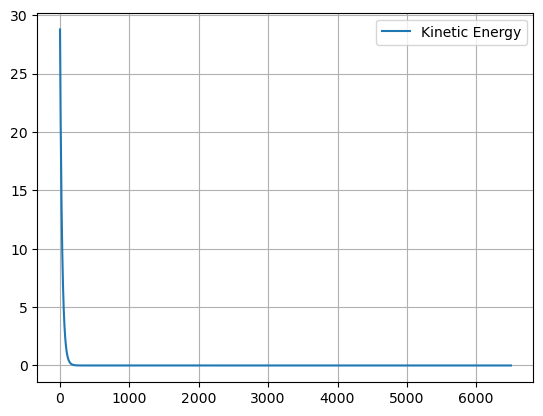

In [42]:
plt.plot(t, T, label='Kinetic Energy')
plt.legend()
plt.grid()

Text(0.5, 0, 'Time')

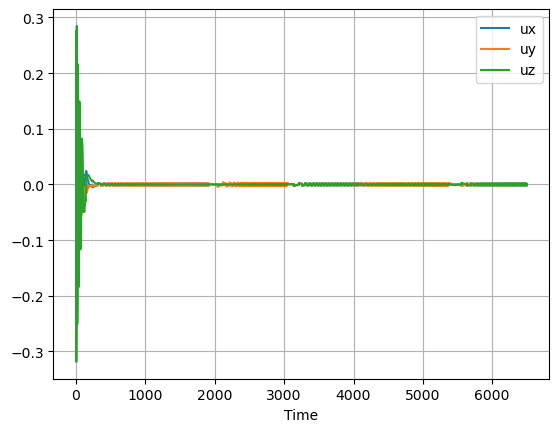

In [49]:
plt.plot(t, control[0,:], label='ux')
plt.plot(t, control[1,:], label='uy')
plt.plot(t, control[2,:], label='uz')
plt.grid()
plt.legend()
plt.xlabel("Time")


Text(0.5, 0, 'Time')

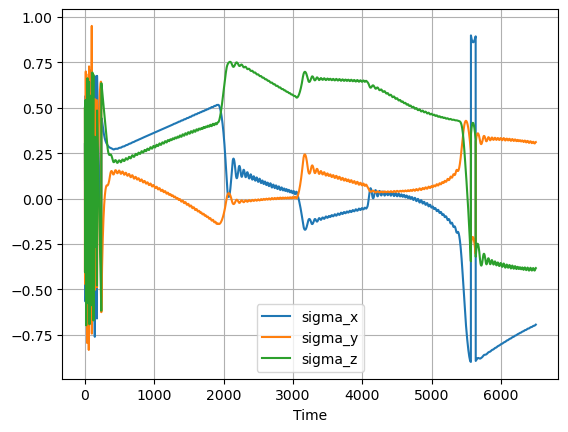

In [50]:
plt.plot(t, states[0,:], label='sigma_x')
plt.plot(t, states[1,:], label='sigma_y')
plt.plot(t, states[2,:], label='sigma_z')
plt.grid()
plt.legend()
plt.xlabel("Time [s]")

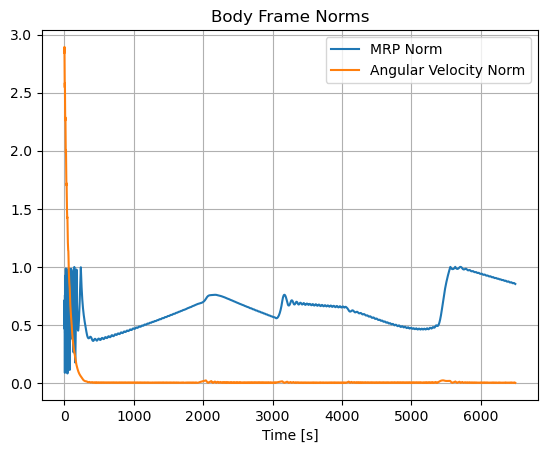

In [57]:
plt.plot(t, norm(states[:3,:], axis=0), label='MRP Norm')
plt.plot(t, norm(states[3:,:], axis=0), label='Angular Velocity Norm')
plt.legend()
plt.title("Body Frame Norms")
plt.xlabel("Time [s]")
plt.grid()


In [357]:
states[:3, 100]

array([-0.23449282,  0.01707563,  0.2415591 ])

In [175]:
for name, error in zip(['comms','sun','nadir'],[comms_error, sun_error, nadir_error]):
    att, rate = error
    print(f"Initial error for {name} orientation: \nAttitude: {norm(att):0.3}\nRate: {norm(rate):0.3} \n")

Initial error for comms orientation: 
Attitude: 0.66
Rate: 2.98 

Initial error for sun orientation: 
Attitude: 0.82
Rate: 2.98 

Initial error for nadir orientation: 
Attitude: 0.461
Rate: 2.98 



In [167]:
norm(dcm2mrp(nadir_orientation))

In [139]:
omega_RsN(300)

array([ 0.00015131, -0.00041572,  0.00076626])

In [141]:
times = np.linspace(0, 3600*1.5 ,1000)
omegas_comms = norm(list(map(lambda t: omega_RcN(t, 1), times)),axis=1)
omegas_sun = norm(list(map(lambda t: omega_RsN(t), times)),axis=1)
omegas_nadir = norm(list(map(lambda t: omega_RnN(t), times)),axis=1)

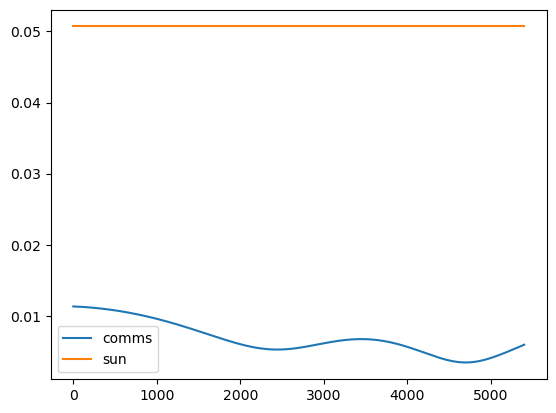

In [149]:
plt.plot(times,omegas_comms*180/np.pi, label='comms') # arcseconds
plt.plot(times,omegas_sun*180/np.pi, label='sun') # arcseconds
# plt.plot(times,omegas_nadir*180/np.pi, label='nadir') # arcseconds
plt.legend()

In [37]:
time_LMO = np.linspace(0, 1*3600, 501)
thetas_LMO = theta_circular(r_LMO, time_LMO, theta0_LMO)

time_GMO = np.linspace(0, 1*3600, 501)
thetas_GMO = theta_circular(r_GMO, time_LMO, theta0_GMO)

dcms_LMO = list(map(lambda theta: orbit_dcm(raan_LMO, inc_LMO, theta), thetas_LMO))
position_LMO = np.array(list(map(lambda dcm: inertial_position(r_LMO, dcm), dcms_LMO)))


dcms_GMO = list(map(lambda theta: orbit_dcm(raan_GMO, inc_GMO, theta), thetas_GMO))
position_GMO = np.array(list(map(lambda dcm: inertial_position(r_GMO, dcm), dcms_GMO)))

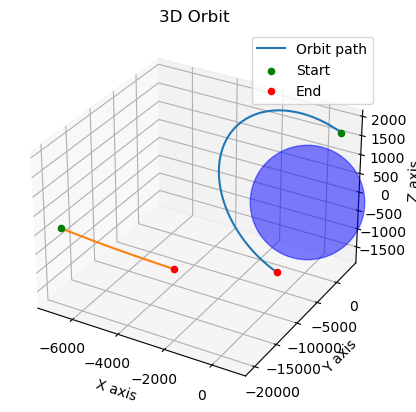

In [39]:
# Creating the plot
position = position_LMO

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x,y,z = position[:,0], position[:,1], position[:,2]
# Plotting the orbit
ax.plot(x, y, z, label='Orbit path')
ax.scatter(x[0], y[0], z[0], color="green", label="Start")  # Mark start of orbit
ax.scatter(x[-1], y[-1], z[-1], color="red", label="End")  # Mark end of orbit
ax.scatter(0,0,0, color="blue", s=2*R_MARS, alpha=0.5)


# xe, ye, ze = dcm_RcN(time_LMO[-1]) @ position_LMO[-1,:]

# ax.quiver(x[-1], y[-1], z[-1], xe, ye, ze, color='black', label='Velocity Vector')


position = position_GMO
x,y,z = position[:,0], position[:,1], position[:,2]
# Plotting the orbit
ax.plot(x, y, z)
ax.scatter(x[0], y[0], z[0], color="green")  # Mark start of orbit
ax.scatter(x[-1], y[-1], z[-1], color="red")  # Mark end of orbit



# Adding labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Orbit')
ax.legend()

# Show plot
plt.show()

In [ ]:

from mpl_toolkits.mplot3d import Axes3D

def plot_orbit(position):
x
    # Creating the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x,y,z = position[:,0], position[:,1], position[:,2]
    # Plotting the orbit
    ax.plot(x, y, z, label='Orbit path')
    ax.scatter(x[0], y[0], z[0], color="green", label="Start")  # Mark start of orbit
    ax.scatter(x[-1], y[-1], z[-1], color="red", label="End")  # Mark end of orbit
    ax.scatter(0,0,0, color="blue", s=2*R_MARS, alpha=0.5)

    # Adding labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Orbit')
    ax.legend()

    # Show plot
    plt.show()
